In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation 
import pickle
import sys, os
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

sys.path.insert(0, os.path.join("..", "source"))
import mass_spring_model
from simulation_util import SummaryFunctions

In [2]:
def get_ensemble(filepath, num_units=3, num_nodes=8, has_light_col=False):  # move all this stuff to source code
    ensemble_data = pickle.load(open(filepath,"rb"))
    headers = ["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
        f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
        for i in range(num_units)]).flatten().tolist() + np.array([[f"x{i}", f"y{i}"]
        for i in range(num_nodes)]).flatten().tolist() 
    if has_light_col: 
        headers = ["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
            f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
            for i in range(num_units)]).flatten().tolist() + ["light_x"] + np.array([[f"x{i}", f"y{i}"]
            for i in range(num_nodes)]).flatten().tolist() 
    return [pd.DataFrame(x, columns=headers) for x in ensemble_data]

def diff(lst, a=np.pi): # successive differences in R/[-a,a] ("else 0" is an approxiamtion)
    return [lst[i]-lst[i-1] if abs(lst[i]-lst[i-1])<a else 0 for i in range(1,len(lst))]

def v_x_angle(df, num_nodes=8, init_angle=5/4 * np.pi, with_light=False):
    sol_col = np.array([[f"x{i}", f"y{i}"] for i in range(num_nodes)]).flatten().tolist()
    df = df.assign(comx=df[sol_col[::2]].mean(axis=1),comy=df[sol_col[1::2]].mean(axis=1))
    df = df.assign(vx=[0] + [(df.comx[i]-df.comx[i-1])/(df.t[i]-df.t[i-1]) for i in range(1,len(df.comx))])
    shifted = np.array([x.to_numpy()-df[["comx","comy"]].to_numpy() for x in np.split(df[sol_col],num_nodes,axis=1)])
    df = df.assign(angle=np.rad2deg((init_angle - np.mean([np.unwrap([np.arctan2(*r)-np.arctan2(*v[0]) for r in v]) 
                                               for v in shifted],axis=0))%(2*np.pi)))
    if with_light: return df[["t","comx","comy","vx","angle","light_x"]]
    return df[["t","comx","comy","vx","angle"]]

def to_avg_bins(df, measurement_times):
    df = df.assign(tidx=np.digitize(df["t"], measurement_times)).groupby("tidx").mean()
    empty = pd.DataFrame(columns=df.columns,index=np.arange(1,len(measurement_times)))
    return pd.concat([df, empty[empty.index.isin(df.index) == False]]).sort_index()

def avg_v_x_angle(ensemble, measurement_times):
    return pd.DataFrame(np.array([to_avg_bins(x, measurement_times).to_numpy() for x in ensemble]).mean(axis=0),
                         columns=["t","comx","comy","vx","angle"])

def heatmap(file_subset, extract_func,vary_cols,avg,symm=False,cdct={0.0: 0, 0.01: 1, 0.04: 2, 0.16: 3},with_xy=False):
    grd = zip(file_subset[vary_cols].to_numpy(), file_subset.index)
    hm = np.zeros((4,4))
    for xy, i in grd:
        if with_xy: hm[cdct[xy[1]],cdct[xy[0]]] = extract_func(xy,avg[i])
        else: hm[cdct[xy[1]],cdct[xy[0]]] = extract_func(avg[i])
    if symm:  # artificial symmetrisation because separately generated files sometimes don't exactly match (but are generally close together)
        hm = (hm.T + hm)/2
    return hm

def hm_plot(hm,xlabel,ylabel,title,ax,cdct):
    im = ax.imshow(hm)
    ax.set_xticks(np.arange(hm.shape[0]), labels=cdct.keys())
    ax.set_yticks(np.arange(hm.shape[1]), labels=cdct.keys())
    for i in range(hm.shape[0]):
        for j in range(hm.shape[1]):
            text = ax.text(j, i, f"{str(hm[i,j]):.5}", ha="center", va="center")
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title);
    
def colour_path_plt(df,ax,no_light=False):
    cmap = colormaps["hsv"]; idx = np.linspace(0,1,360)[df.angle.astype(int)]
    scat = ax.scatter(df.comx,df.comy,s=0.01,c=cmap(idx))
    if not no_light:
        switch = np.where(np.concatenate([df.light_x.to_numpy()[1:] != df.light_x.to_numpy()[:-1], [False]]))[0]
        ax.scatter(df.comx[switch], df.comy[switch],s=100,c='black',marker="*")
    ax.scatter(df.comx[0], df.comy[0],s=100,c='black',marker=">")
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax,cmap=cmap,norm=Normalize(vmin=0,vmax=360),ticks=np.arange(19)*20).set_label("angle [deg]")

# 4 block S-shape 

### spread-out amplitudes 0.5 ... 100

In [3]:
dataframes = []; path = os.path.join("..", "data", "sweeps", "13_08_2023", "110_011_rotation_instability_amplitude")
for file in sorted(os.listdir(path),key=lambda x: float(x.split("_")[2][:-3])):
    if file.endswith("600steps.p"):
        print(file)
        dataframes.append([v_x_angle(x) for x in get_ensemble(os.path.join(path,file),4,10,True)])
amplitudes = [0.5,1,3,5,10,20,50,100]

110_011_0.5amp_30sim_600steps.p
110_011_1amp_30sim_600steps.p
110_011_3amp_30sim_600steps.p
110_011_5amp_30sim_600steps.p
110_011_10amp_30sim_600steps.p
110_011_20amp_30sim_600steps.p
110_011_50amp_30sim_600steps.p
110_011_100amp_30sim_600steps.p


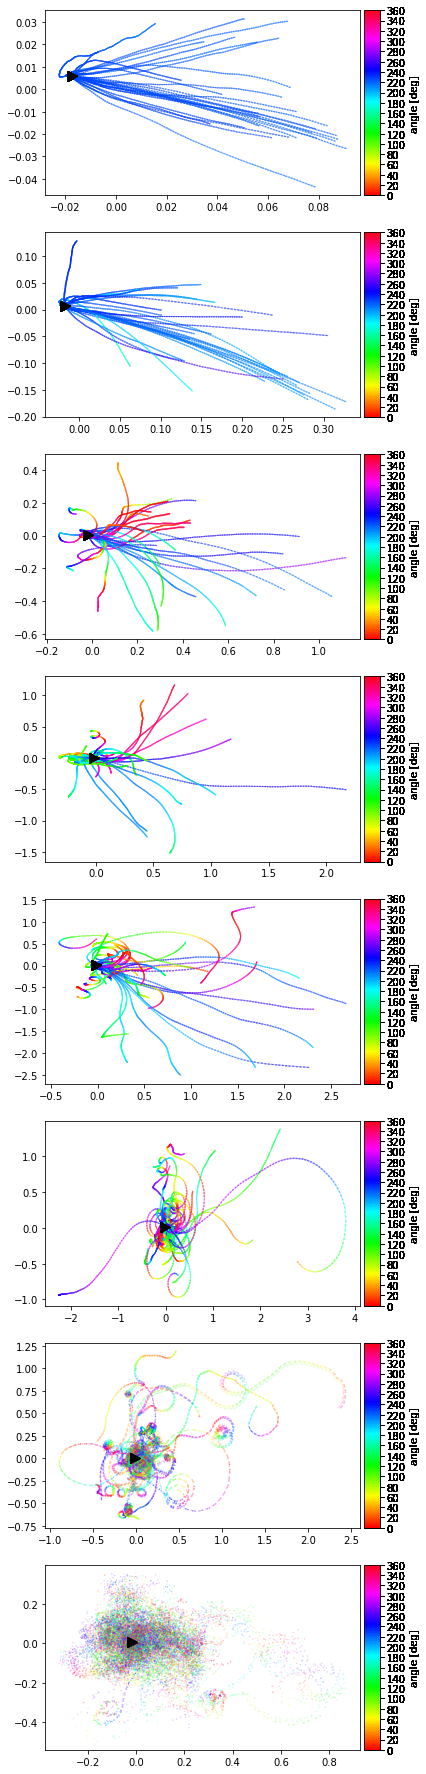

In [4]:
fig, ax = plt.subplots(8,1,figsize=(6,32));
[[colour_path_plt(path,ax[i],True) for path in dataframes[i]] for i in range(len(dataframes))];

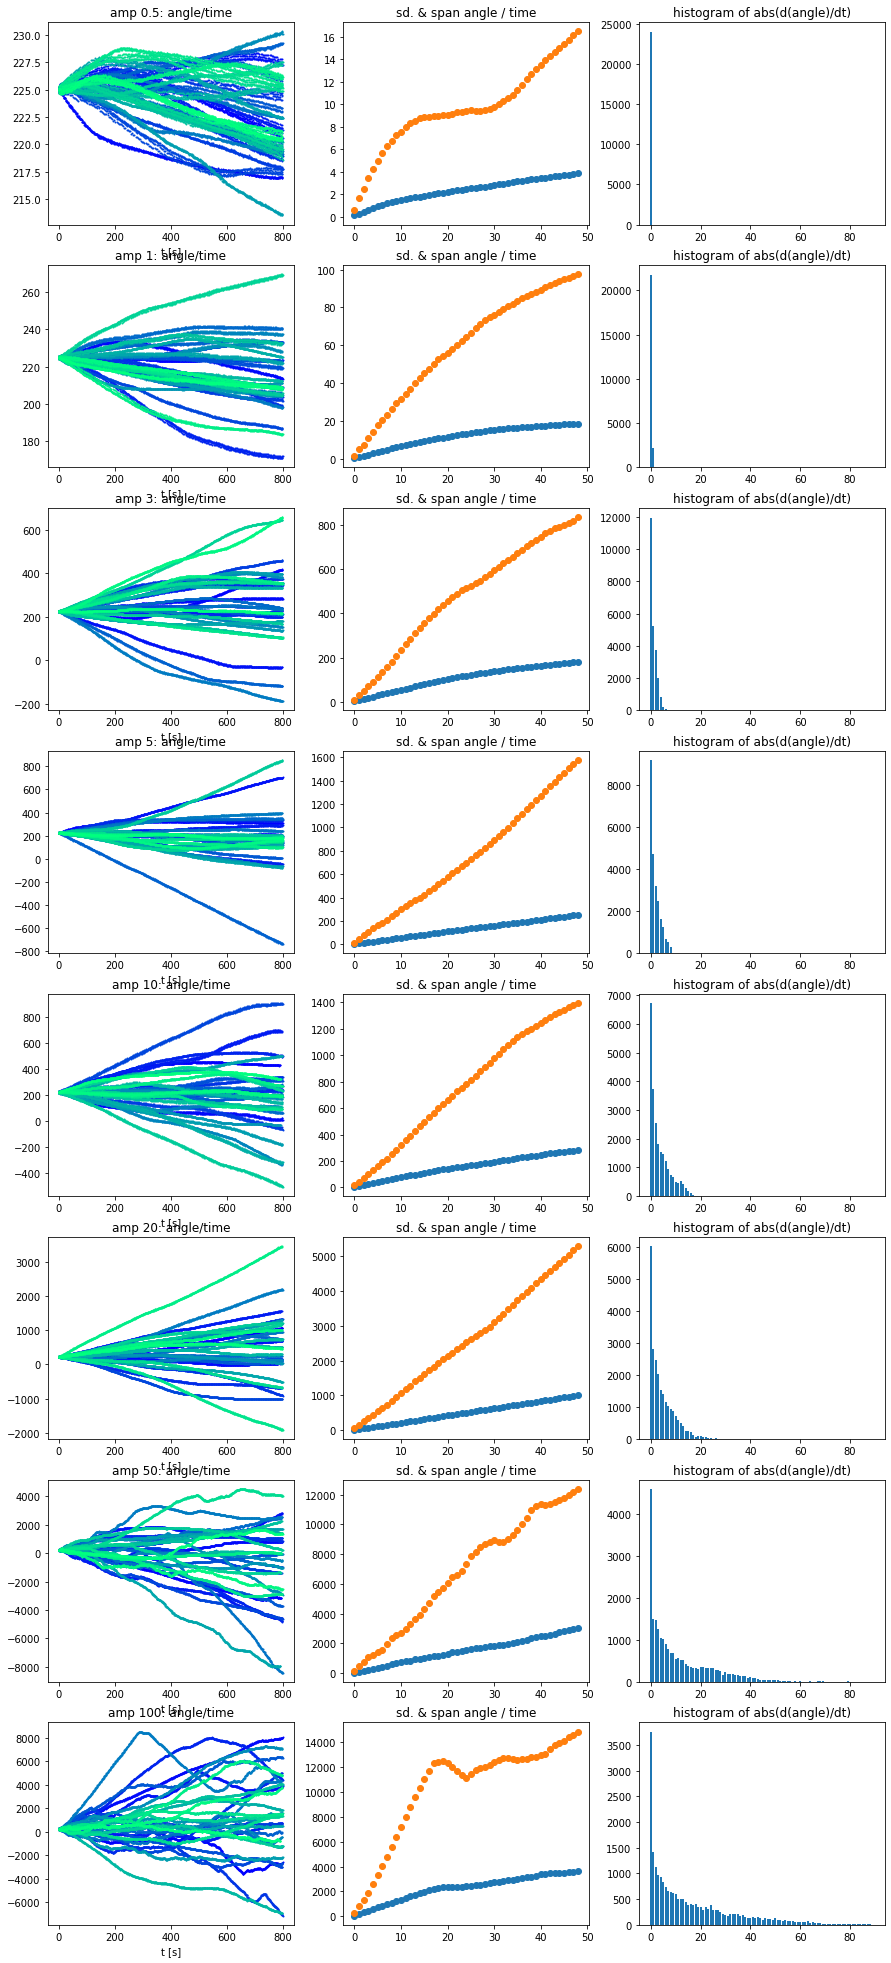

In [5]:
def plots(dataframes,amplitudes):
    fig, ax = plt.subplots(len(dataframes),3,figsize=(15,35))
    cmap = colormaps["winter"]; idx = np.linspace(0,1,len(dataframes[0])); 
    bins = 90; vbins = 50; 
    for j in range(len(dataframes)):
        hist_vals = np.full(bins,0)
        paths = []
        for i in range(len(dataframes[j])):
            path = np.unwrap(dataframes[j][i]["angle"],period=360,discont=180)
            ax[j,0].scatter(np.arange(len(path)),path,s=1.0,color=cmap(idx[i]))
            hist_vals += np.histogram(np.abs(np.diff(path)),bins=np.arange(0,bins+1,1))[0]
            paths.append(to_avg_bins(dataframes[j][i].assign(unwrapped=path),np.linspace(0,600,vbins))["unwrapped"])
        ax[j,0].set_title("amp " + str(amplitudes[j]) + ": angle/time"); ax[j,0].set_xlabel("t [s]");
        ax[j,1].set_title("sd. & span angle / time"); ax[j,0].set_xlabel("t [s]");
        ax[j,1].scatter(np.arange(vbins-1),np.std(paths,axis=0))
        ax[j,1].scatter(np.arange(vbins-1),np.max(paths,axis=0)-np.min(paths,axis=0))
        ax[j,2].bar(np.arange(0,bins,1),hist_vals)
        ax[j,2].set_title("histogram of abs(d(angle)/dt)");
        
plots(dataframes,amplitudes)

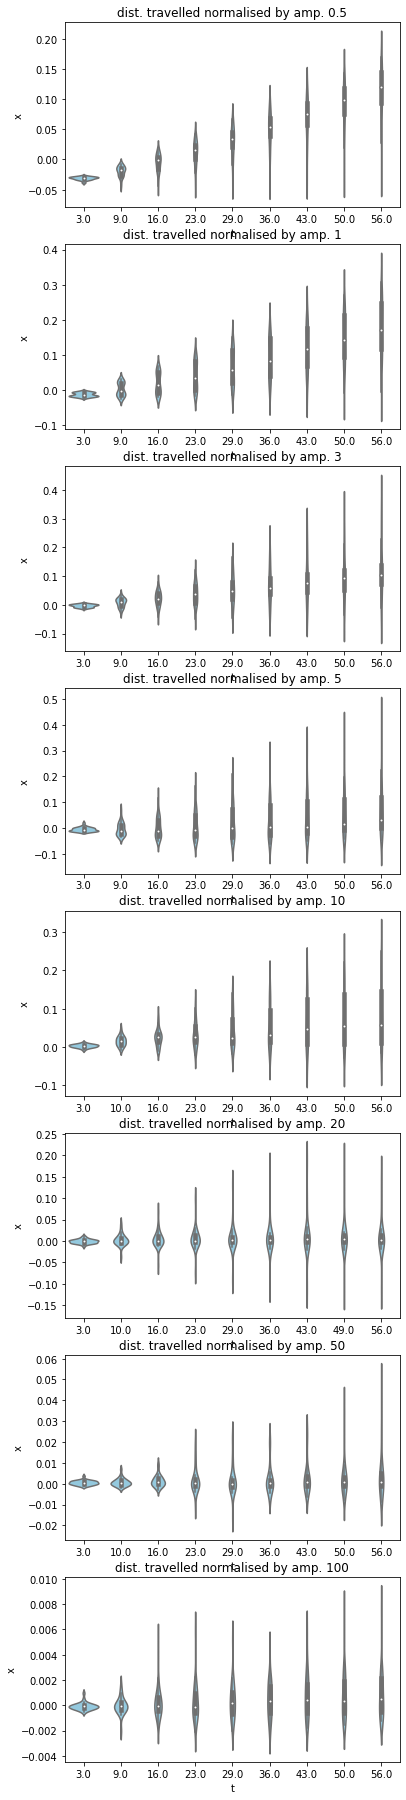

In [6]:
def plots2(dataframes,amplitudes):
    fig, ax = plt.subplots(len(dataframes),1,figsize=(6,32))
    for j in range(len(dataframes)):
        sns.violinplot(data=pd.DataFrame({
            "x":pd.concat([to_avg_bins(x,np.linspace(0,600,10))["comx"]/amplitudes[j] for x in dataframes[j]],ignore_index=True),
            "t":pd.concat([(to_avg_bins(dataframes[j][0],np.linspace(0,600,10))["t"]/10).astype(int) for _ in range(len(dataframes[j]))],ignore_index=True)
        }).astype(float),x="t",y="x",color="skyblue",ax=ax[j])
        ax[j].set_title("dist. travelled normalised by amp. " + str(amplitudes[j]))    

plots2(dataframes,amplitudes)

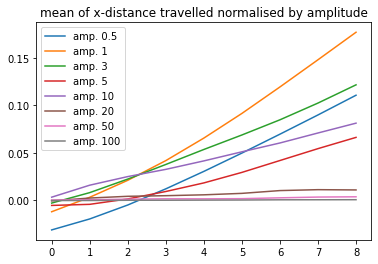

In [7]:
def plot3(dataframes,amplitudes):
    for j in range(len(dataframes)):
        plt.plot(np.arange(9),np.mean([to_avg_bins(x,np.linspace(0,600,10))["comx"]/amplitudes[j] 
                                       for x in dataframes[j]],axis=0),label="amp. " + str(amplitudes[j]))
    plt.legend()
    plt.title("mean of x-distance travelled normalised by amplitude")
    plt.show()
    
plot3(dataframes,amplitudes)

In [82]:
def last_col_plot(dataframes,amplitudes,w=1): 
    combined = [] 
    for j in range(len(dataframes)):
        combined.append(pd.DataFrame({
            "x": [to_avg_bins(x,np.linspace(0,600,20))["comx"].tolist()[-1]/amplitudes[j] for x in dataframes[j]],
            "amp": np.full(len(dataframes[j]), amplitudes[j])}))
    combined = pd.concat(combined,ignore_index=True)
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    sns.violinplot(data=combined,x="amp",y="x",width=w,color="skyblue")

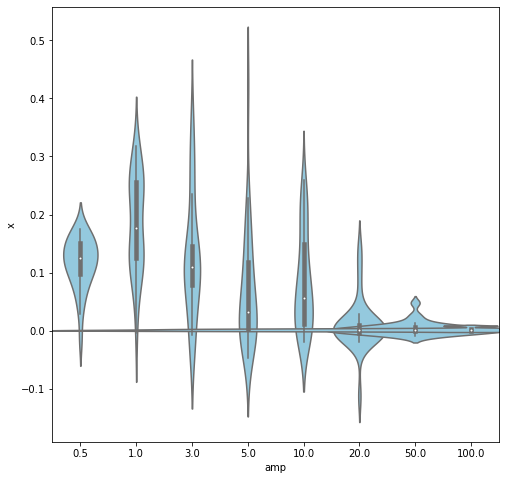

In [83]:
last_col_plot(dataframes,amplitudes,15)

### densely clustered amplitudes 0.5 ... 3

In [26]:
dataframes2 = []; path = os.path.join("..", "data", "sweeps", "27_08_2023", "110_011_rotation_instability_amplitude")
for file in sorted(os.listdir(path),key=lambda x: float(x.split("_")[2][:-3])):
    if file.endswith("600steps.p"):
        print(file)
        dataframes2.append([v_x_angle(x) for x in get_ensemble(os.path.join(path,file),4,10,True)])
        
amplitudes2 = [0.5,1,1.5,2,2.5,3]

110_011_0.5amp_30sim_600steps.p
110_011_1amp_30sim_600steps.p
110_011_1.5amp_30sim_600steps.p
110_011_2amp_30sim_600steps.p
110_011_2.5amp_30sim_600steps.p
110_011_3amp_30sim_600steps.p


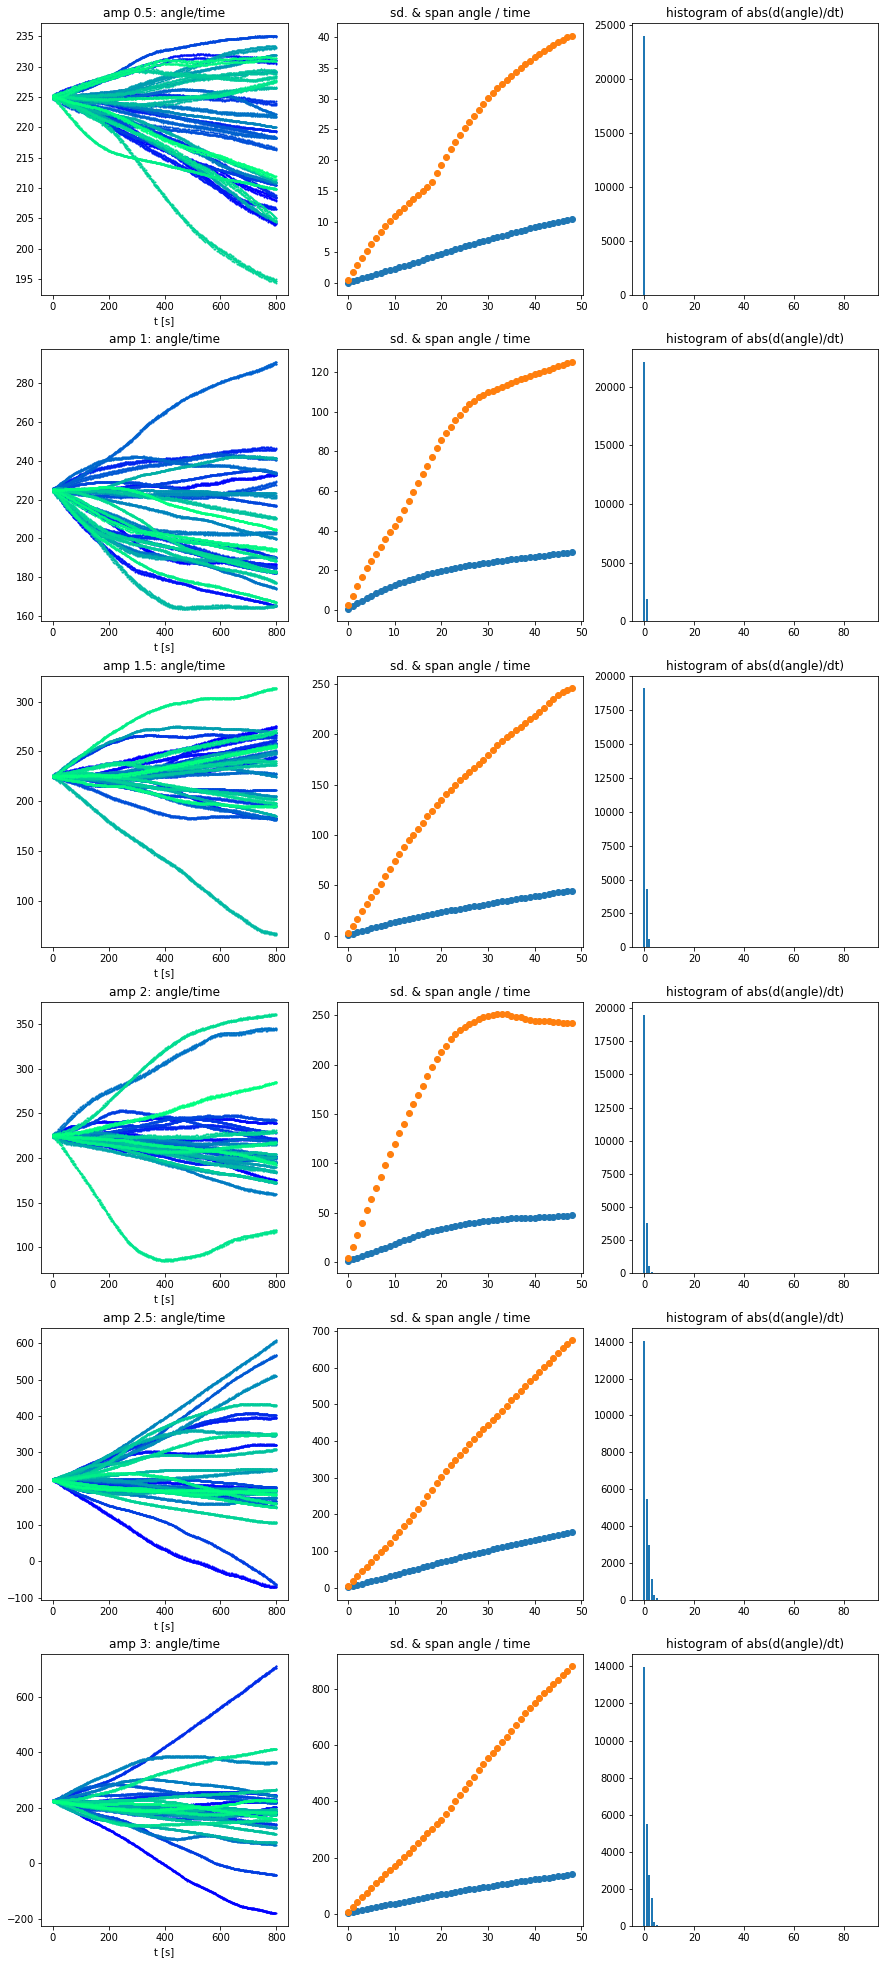

In [27]:
plots(dataframes2,amplitudes2)

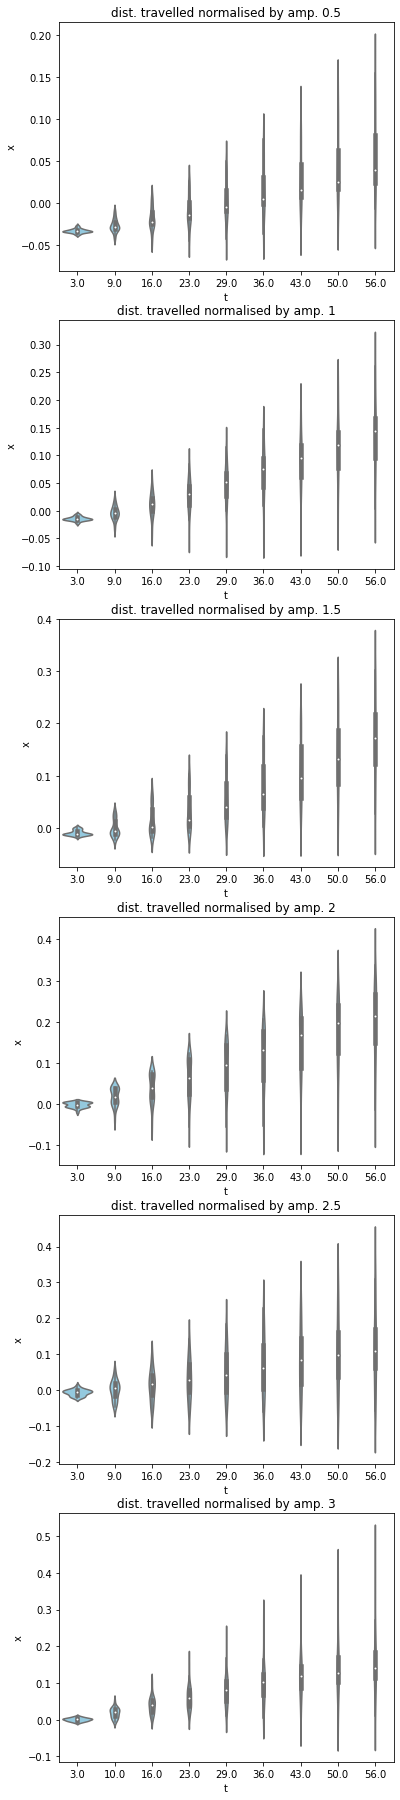

In [28]:
plots2(dataframes2,amplitudes2)

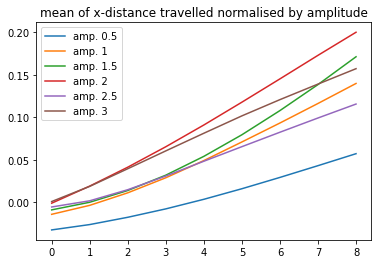

In [29]:
plot3(dataframes2,amplitudes2)

In [84]:
last_col_plot(dataframes2,amplitudes2)

ValueError: No objects to concatenate

# 3 block triangle shape

In [76]:
dataframes3 = []; amplitudes3 = []; path = os.path.join("..", "data", "sweeps", "12_09_2023", "11_01_rotation_instability_amplitude")
for file in sorted(os.listdir(path),key=lambda x: float(x.split("_")[2][:-3])):
    if file.endswith("600steps.p"):
        print(file)
        amplitudes3.append(float(file.split("_")[2][:-3]))
        dataframes3.append([v_x_angle(x) for x in get_ensemble(os.path.join(path,file),3,8,True)])
        

11_01_0.25amp_30sim_600steps.p
11_01_0.5amp_30sim_600steps.p
11_01_1amp_30sim_600steps.p
11_01_1.5amp_30sim_600steps.p
11_01_2amp_30sim_600steps.p
11_01_2.5amp_30sim_600steps.p
11_01_3amp_30sim_600steps.p
11_01_3.5amp_30sim_600steps.p
11_01_5amp_30sim_600steps.p


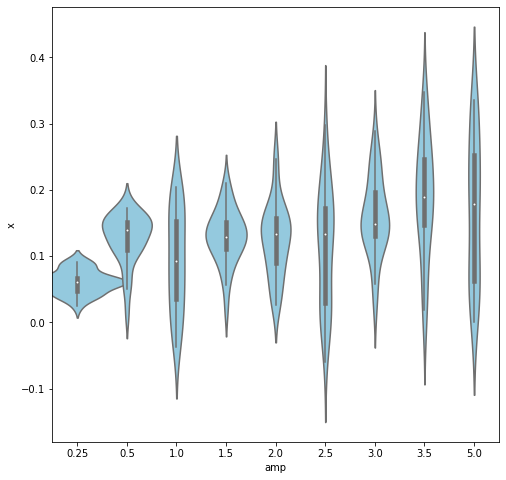

In [78]:
last_col_plot(dataframes3,amplitudes3,w=2)

# 5 block wide L-shape with random amplitude distributions 


In [41]:
def extract2(st): 
    return eval(st.split("_")[5][:-3])

dataframes4 = []; amplitudes4 = []; path = os.path.join("..", "data", "sweeps", "13_09_2023", "11111_00001_00001_00001_00001_rotation_instability_amplitude")
for file in sorted(os.listdir(path)):
    if file.endswith("600steps.p"):
        print(file)
        dataframes4.append([v_x_angle(x) for x in get_ensemble(os.path.join(path,file),9,20,True)])
        amplitudes4.append(extract2(file))
        

11111_00001_00001_00001_00001_[1.597343629320139, 2.4585997801741617, 2.2776622677851623, 2.5664540510280993, 2.01888041621573, 3.361873921707084, 2.0904316613688048, 2.382650928124892, 3.0188254152513005]amp_30sim_600steps.p
11111_00001_00001_00001_00001_[1.8613070259932143, 2.077095392537569, 1.1017403685731693, 0.9050193478616684, 3.307988043563119, 1.7366559209344754, 3.079044101077981, 1.713346292308599, 3.045158466071145]amp_30sim_600steps.p
11111_00001_00001_00001_00001_[2.235405467260284, 1.862791249614758, 2.9765071688805462, 1.4428342481606173, 2.4290644911192825, 0.7451515662991848, 2.467893281454195, 1.6431540699408775, 2.7812545699836573]amp_30sim_600steps.p
11111_00001_00001_00001_00001_[2.399598589908903, 1.1562713189748486, 2.994566021179198, 1.0515115016847394, 0.5738248566724571, 1.0221998881493999, 1.943731885575247, 2.8481832850090205, 3.047140904286577]amp_30sim_600steps.p
11111_00001_00001_00001_00001_[2.4107499376420782, 2.747839521185557, 2.15235490446845, 0.901

In [66]:
ampdct4 = dict(zip(np.round(np.mean(amplitudes4,axis=1),2),amplitudes4))

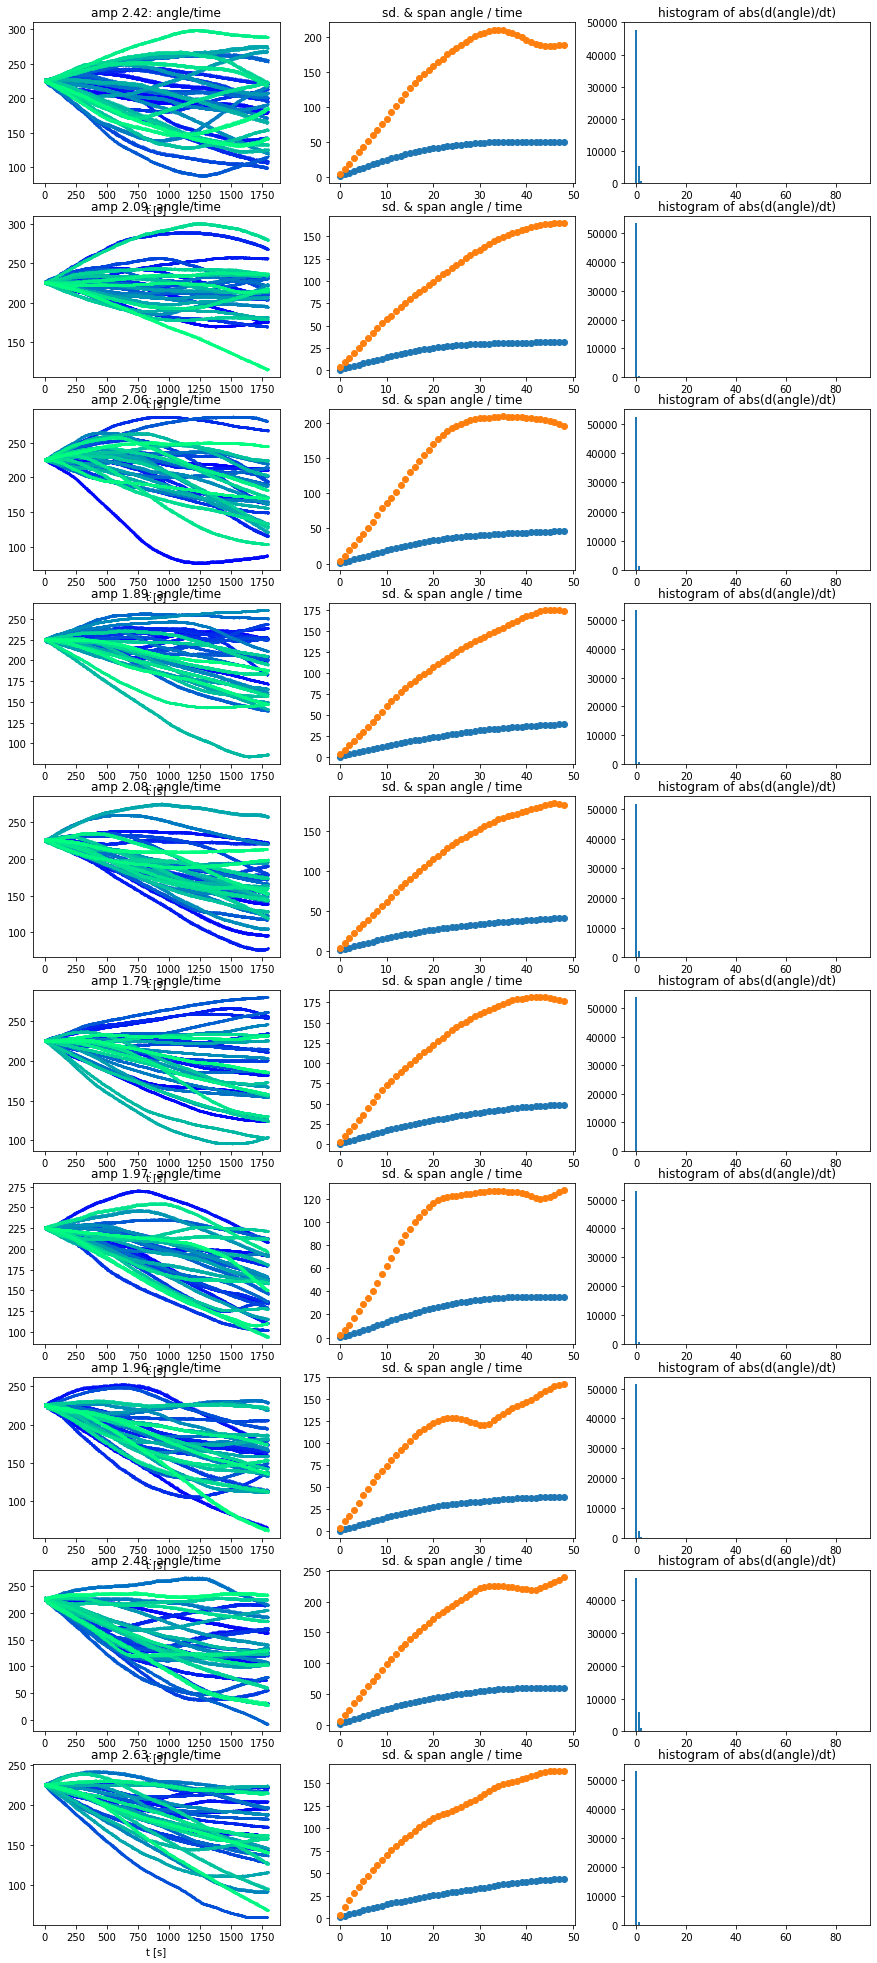

In [62]:
plots(dataframes4,np.round(np.mean(amplitudes4,axis=1),2))

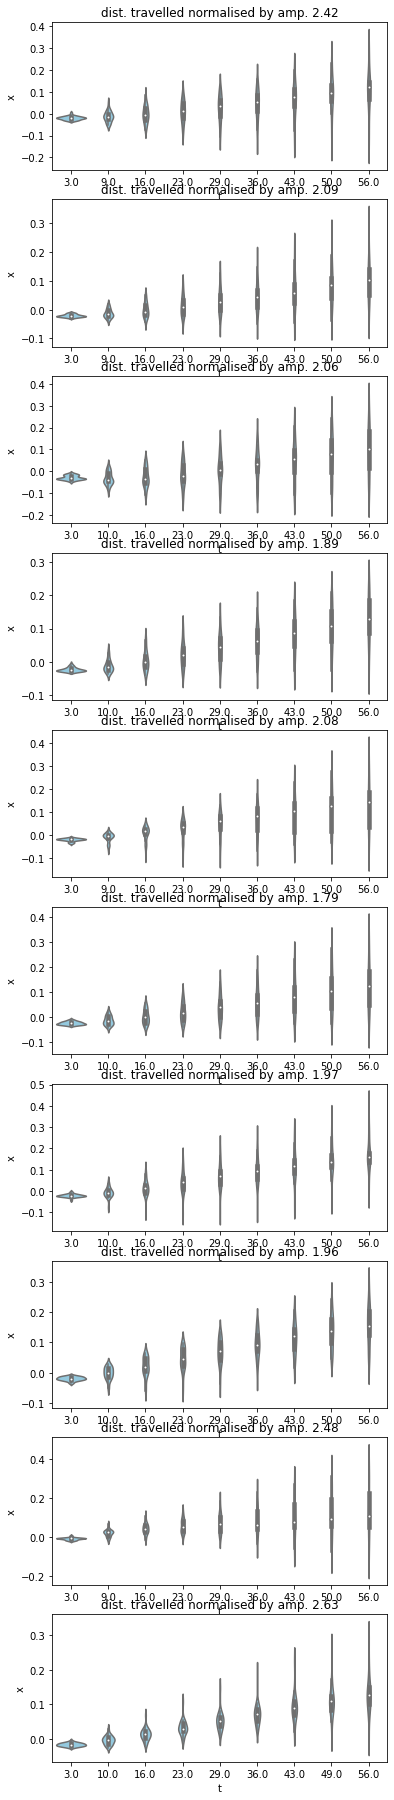

In [63]:
plots2(dataframes4,np.round(np.mean(amplitudes4,axis=1),2))

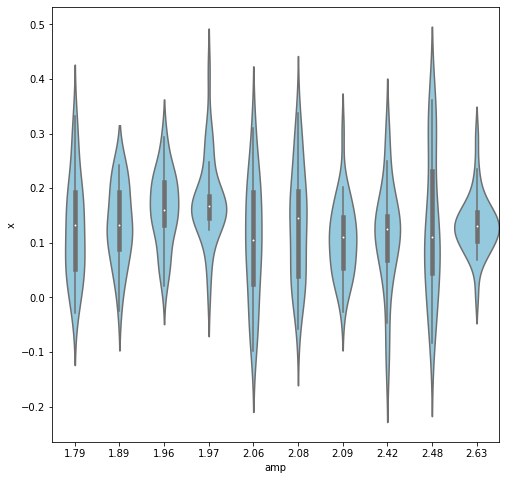

In [61]:
last_col_plot(dataframes4,np.round(np.mean(amplitudes4,axis=1),2))

In [68]:
ampdct4[1.97]

[2.785247883517561,
 2.4073578132005315,
 2.202900727181582,
 2.7639616662325084,
 0.33494222058575773,
 1.4692180581125944,
 0.6738669524263963,
 2.4053324595645007,
 2.646139571053123]